In [1]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import time

def display_image(image):
    fig, axes = plt.subplots(figsize=(6, 4))

    if image.ndim == 2:
        axes.imshow(image, cmap='gray', vmin=0, vmax=255)
    else:
        axes.imshow(image)

    plt.show()

def display_image_pair(first_image, second_image):
    #this funciton from Computer vision course notes 
    # When using plt.subplots, we can specify how many plottable regions we want to create through nrows and ncols
    # Here we are creating a subplot with 2 columns and 1 row (i.e. side-by-side axes)
    # When we do this, axes becomes a list of length 2 (Containing both plottable axes)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    
    # TODO: Call imshow on each of the axes with the first and second images
    #       Make sure you handle both RGB and grayscale images
    if first_image.ndim == 2:
        axes[0].imshow(first_image, cmap='gray', vmin=0, vmax=255)
    else:
        axes[0].imshow(first_image)

    if second_image.ndim == 2:
        axes[1].imshow(second_image, cmap='gray', vmin=0, vmax=255)
    else:
        axes[1].imshow(second_image)

    plt.show()

def load_img(filename):
    img = cv2.imread(filename)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [2]:
def do_kmeans(filtered_image, n_samples = 5):
    pixels = filtered_image.reshape(-1, 1)

    np.random.seed(42)

    # Define the size of the random sample
    sample_size = 3000

    # Take a random sample from the pixels array
    random_sample = np.random.choice(pixels.flatten(), size=sample_size)
    random_sample=random_sample.reshape(-1,1)


    # Perform k-means clustering
    k = n_samples  # Number of clusters
    kmeans = KMeans(n_clusters=k, random_state=0,n_init=10)
    kmeans.fit(random_sample)#pixels)
    
    cluster_centers = kmeans.cluster_centers_
    clusters = kmeans.predict(pixels)
    

    clustered_image = cluster_centers[clusters].reshape(filtered_image.shape)
    # Convert the spread image to 8-bit for visualization
    clustered_image = np.uint8(clustered_image)
    dists = ((255-cluster_centers)*4/255)
    return clustered_image, cluster_centers

def get_segemntation(clustered_image, cluster_centers,min_region_size=1000):
    num_grps = len(cluster_centers)
    gray_level_ranges = [(*i-1, *i+1) for i in cluster_centers]
    
    segmentation_masks = [] #np.zeros_like(clustered_image, dtype=np.uint8)
    stats = []
    lbls = []
    for i, (min_level, max_level) in enumerate(gray_level_ranges):
        segmentation_mask = np.zeros_like(clustered_image, dtype=bool)#np.uint8)
        # Apply thresholding to create a binary image for the current region
        _, binary_image = cv2.threshold(clustered_image, min_level, 255, cv2.THRESH_BINARY)
        _, upper_thresholded = cv2.threshold(clustered_image, max_level, 255, cv2.THRESH_BINARY_INV)
        binary_image = cv2.bitwise_and(binary_image, upper_thresholded)

        # Apply connected component labeling
        
        num_labels_, labels_, stats_, _ = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
        

        # Assign a unique label to the corresponding pixels in the segmentation masks
        p = 1
        for p, st in enumerate(stats_):# range(q, q+num_labels_-1):
            if p==0:
                continue        
            elif st[cv2.CC_STAT_AREA] < min_region_size:
                segmentation_mask[labels_ == p] = 0
                
            else:
                stats.append(st)
                segmentation_mask[labels_ == p] =True #cluster_centers[i]
                segmentation_masks.append(segmentation_mask)
                lbls.append(cluster_centers[i]) #(255.0-cluster_centers[i])*400.0/255.0)

    sorted_index = sorted(range(len(lbls)), key=lambda k: lbls[k])

    # Sort l1
    lbls = sorted(lbls)

    # Reorder l2 and l3 using the sorted index
    stats = [stats[i] for i in sorted_index]
    segmentation_masks = [segmentation_masks[i] for i in sorted_index]    
    return lbls,stats,segmentation_masks
        
    

(180, 240, 3)


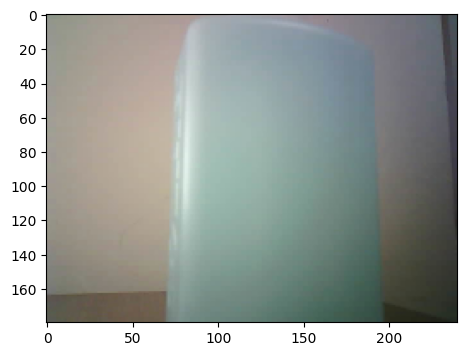

In [3]:
image_esp32 = load_img('./outputs/esp32_10.jpg')
image_esp32 = cv2.resize(image_esp32,(240,180),interpolation=cv2.INTER_CUBIC)
print(image_esp32.shape)
xx = image_esp32.shape[1]
yy = image_esp32.shape[0]
display_image(image_esp32)#, filtered_image)

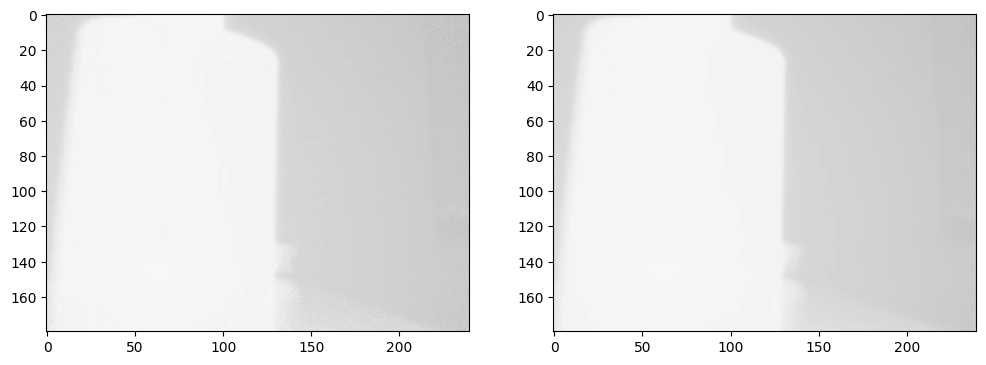

In [4]:
# Read the grayscale image
image = cv2.imread('./outputs/tof_10.jpg', 0)

#use a median filter to get rid of the noise
filtered_image = cv2.medianBlur(image, 5) 

display_image_pair(image, filtered_image)

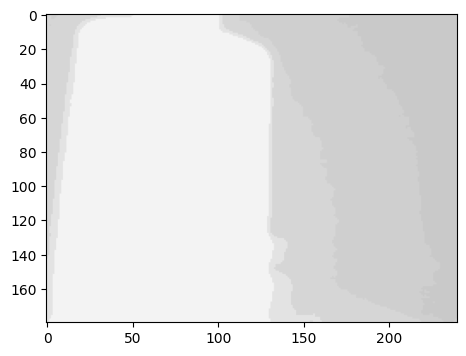

In [5]:
clustered_image, cluster_centers = do_kmeans(filtered_image, n_samples = 5)
lbls,stats,segmentation_masks = get_segemntation(clustered_image, cluster_centers)
display_image(clustered_image)

#### Calculate the P value, which is the number of pixels we need to shift the corresponding segmentation mask to the right

In [6]:
#these are teh parameters of the camera.
fl = 2.043636363636363
tantheta = 0.51#648732789907391
dc = 4.0 #cm distance between cameras
distance = ((255.0-np.array(lbls))*400.0/255.0-2.0) #add 0.001 to hack divide by zero error
P = (xx*dc/(2*tantheta))/distance

### Now I have my segmentation masks and the P value, I can overlay my masks

In [7]:
#first shift the segmentation mask
shifted_masks = []
shifted_stats = []
for i, p_val in enumerate(P):
    st = np.copy(stats[i])
    st[0] = st[0]+int(p_val)
    st[2] = min(xx, st[2])
    #tack this onto the left side of the mask
    left_side = np.zeros((yy,int(p_val)), dtype=bool)
    s_mask = np.concatenate((left_side,segmentation_masks[i]),axis=1)
    s_mask = s_mask[:yy,:xx]
    shifted_masks.append(s_mask)
    shifted_stats.append(st)
#next do stats

    

In [8]:
COLOURS = [
    tuple(int(colour_hex.strip('#')[i:i+2], 16) for i in (0, 2, 4))
    for colour_hex in plt.rcParams['axes.prop_cycle'].by_key()['color']
]

In [9]:
def draw_instance_segmentation_masks(img, masks):
    ''' Draws coloured polygons masks over img '''
    filled = np.zeros_like(img)
    # image_ret = img.copy()
    
    for i, mask in enumerate(masks):
        if i==(len(masks) -1):
            filled[mask] = COLOURS[i]
    # Blend original and filled into a composite image
    cv2.addWeighted(img, 0.75, filled, 0.45, 0.0, dst=img)
    
def draw_detections(img, stts, colours=COLOURS):
    for i, (tlx, tly, w, h, d) in enumerate(stts):
        if i== len(stts)-1:
            i %= len(colours)
            cv2.rectangle(img, (tlx, tly), (tlx+w, tly+h), color=colours[i], thickness=2)
            
def annotate_distance(img, dist, stts, colours=COLOURS):
    for i, (tlx, tly, w, h, d) in enumerate(stts):
        if i == len(stts)-1:
            
            txt = f'{dist[i][0]:1.1f} cm'

            offset = 1

            # cv2.rectangle(img, 
            #               (tlx+offset, tly+offset+12),
            #               (tlx+offset+len(txt)*12, tly),
            #               color=colours[i],
            #               thickness=cv2.FILLED)

            ff = cv2.FONT_HERSHEY_PLAIN
            cv2.putText(img, txt, (tlx, tly+12), fontFace=ff, fontScale=1.0, color=(255,)*3)
        

In [10]:
img_out = np.copy(image_esp32)
draw_instance_segmentation_masks(img_out, shifted_masks)
draw_detections(img_out,shifted_stats)
annotate_distance(img_out, distance, shifted_stats)

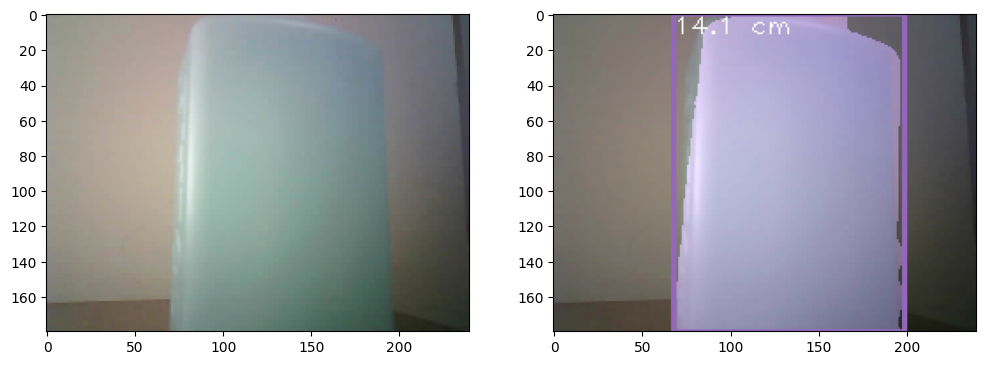

In [11]:
display_image_pair(image_esp32,img_out)

In [ ]:
yy